## Notebook Purpose and Scope

This notebook benchmarks the ODER entropy retrieval law against analytic baselines and cognitive-inspired mechanistic foils using fixed synthetic traces. Its objective is to validate ODER’s retrieval performance, model parsimony, and diagnostic capacity under standardized input conditions.

---

### Objectives

- Evaluate ODER against:
  - Analytic baselines: linear, exponential, power-law
  - Mechanistic foils: surprisal-aligned exponential, ACT-R buffer decay
- Report ΔAIC and R² using matched fitting routines and bounded parameter spaces
- Confirm that ODER’s advantages are not due to trivial baseline comparisons or overfitting

---

### Technical Configuration

| Component                   | Status       | Description                                                                 |
|----------------------------|--------------|-----------------------------------------------------------------------------|
| Model architecture          | ✅ Closed-form | All models are analytic; no simulation or ODE solvers are used            |
| Fit procedure               | ✅ Matched     | All models use the same optimizer (`curve_fit`), bounds, and time domain  |
| AIC formulation             | ✅ Correct     | AIC computed using 2k + n·log(RSS/n)                                       |
| Output clipping             | ✅ Enforced    | All retrieval curves clipped to [0, Sₘₐₓ] using `np.clip`                  |
| Reproducibility             | ✅ Guaranteed  | Random seed fixed; no stochastic components in fit scoring                 |
| Surprisal input             | 🟡 Synthetic   | Placeholder values used; flagged for later replacement                     |

> **Note**: The surprisal input is a synthetic linear ramp (`np.linspace`). Replace with corpus-derived token-level surprisals in empirical applications.

---

### Scope and Limitations

This notebook is designed exclusively for structural benchmarking and fit comparison. It does **not** compute:

- Observer-specific contextual gradient (∇C)
- Retrieval-collapse time (τ₍res₎)
- Comprehension divergence detection
- EEG or behavioral signal alignment
- ACT-R memory stack dynamics
- LM-based or contextual surprisal variation

It is not intended to support empirical trace modeling or comprehension-state prediction.

---

### Use Context

This notebook supports:

- ΔAIC benchmarking of entropy-retrieval models
- Fit parsimony validation
- Reproducibility and methods transparency for publication or review

It is suitable for internal verification, peer review submission, or supplementary methods documentation.




In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Reproducibility
np.random.seed(42)

# -------------------------------
# Models
# -------------------------------
def oder_model(t, gamma, tau_char, S_max=1.0):
    y = S_max * (1 - np.exp(-gamma * t * np.tanh(t / tau_char)))
    return np.clip(y, 0.0, S_max)

def linear_model(t, alpha, S_max=1.0):
    return np.clip(alpha * t, 0.0, S_max)

def exponential_model(t, tau, S_max=1.0):
    y = S_max * (1 - np.exp(-t / tau))
    return np.clip(y, 0.0, S_max)

def power_law_model(t, beta, c, S_max=1.0):
    y = S_max * (1 - (1 + t / c)**(-beta))
    return np.clip(y, 0.0, S_max)

def surprisal_exponential(t, alpha, surprisal_values, S_max=1.0):
    cum_s = np.cumsum(surprisal_values[:len(t)])
    y = S_max * (1 - np.exp(-alpha * cum_s))
    return np.clip(y, 0.0, S_max)

def actr_buffer_decay(t, tau, capacity=4, S_max=1.0):
    eff = np.minimum(t, capacity)
    y = S_max * (1 - np.exp(-eff / tau))
    return np.clip(y, 0.0, S_max)

# -------------------------------
# Fit + AIC
# -------------------------------
def aic_from_rss(n, rss, k):
    return 2 * k + n * np.log(rss / n)

def fit_and_score(model_fn, x, y, bounds, label):
    popt, _ = curve_fit(model_fn, x, y, bounds=bounds, maxfev=100000)
    y_hat = model_fn(x, *popt)
    rss = np.sum((y - y_hat)**2)
    r2 = r2_score(y, y_hat)
    k = len(popt)
    aic = aic_from_rss(len(y), rss, k)
    return {"Model": label, "Params": popt, "R2": r2, "AIC": aic}

# -------------------------------
# ODER-style trace
# -------------------------------
true_gamma, tau_char_true = 0.69, 0.10
t = np.arange(1, 13, dtype=float)

S_true = oder_model(t, true_gamma, tau_char_true)
S_obs = np.clip(S_true + np.random.normal(0, 0.01, len(t)), 0.0, 1.0)

# Synthetic surprisal values (can replace later)
surprisal_values = np.linspace(0.5, 2.0, len(t))
surprisal_closure = lambda tt, alpha: surprisal_exponential(tt, alpha, surprisal_values)

# -------------------------------
# Fit all models
# -------------------------------
results = []
results.append(fit_and_score(lambda tt, g, tau: oder_model(tt, g, tau),
                             t, S_obs, ([0.01, 0.05], [2.0, 1.0]), "ODER"))
results.append(fit_and_score(lambda tt, a: linear_model(tt, a),
                             t, S_obs, ([0.0], [1.0]), "Linear"))
results.append(fit_and_score(lambda tt, tau: exponential_model(tt, tau),
                             t, S_obs, ([0.05], [5.0]), "Exponential"))
results.append(fit_and_score(lambda tt, b, c: power_law_model(tt, b, c),
                             t, S_obs, ([0.1, 0.1], [5.0, 10.0]), "PowerLaw"))
results.append(fit_and_score(surprisal_closure,
                             t, S_obs, ([0.01], [5.0]), "Surprisal"))
results.append(fit_and_score(lambda tt, tau: actr_buffer_decay(tt, tau),
                             t, S_obs, ([0.1], [10.0]), "ACT-R"))

# -------------------------------
# ΔAIC
# -------------------------------
df = pd.DataFrame(results)

if "ODER" in df["Model"].values:
    df["ΔAIC"] = df["AIC"] - df.loc[df["Model"] == "ODER", "AIC"].values[0]
else:
    raise ValueError("Model 'ODER' not found in results — check model fit entries.")

df.sort_values("ΔAIC")


,Model,Params,R2,AIC,ΔAIC
2,Exponential,[1.4272544675828336],0.998492,-122.524583,-1.994047
0,ODER,"[0.7010163632409957, 0.2792105637832049]",0.998493,-120.530536,0.000000
4,Surprisal,[1.2491548372996504],0.984729,-94.744621,25.785916
3,PowerLaw,"[4.999999999999927, 6.076281581822727]",0.986041,-93.822518,26.708019
5,ACT-R,[1.2681890845895751],0.939935,-78.310785,42.219751
1,Linear,[0.5033910699866697],0.668133,-57.799090,62.731447


## **Visual Comparison of Fitted Models**

This cell plots the fitted entropy-retrieval curves from all six models — ODER, Linear, Exponential, Power-law, Surprisal, and ACT-R — against the synthetic trace used in benchmarking (`S_obs`). It provides a visual complement to the ΔAIC and R² results, highlighting where models align or diverge from the observed retrieval trajectory. All fits are generated using the parameter estimates from the previous benchmarking cell.


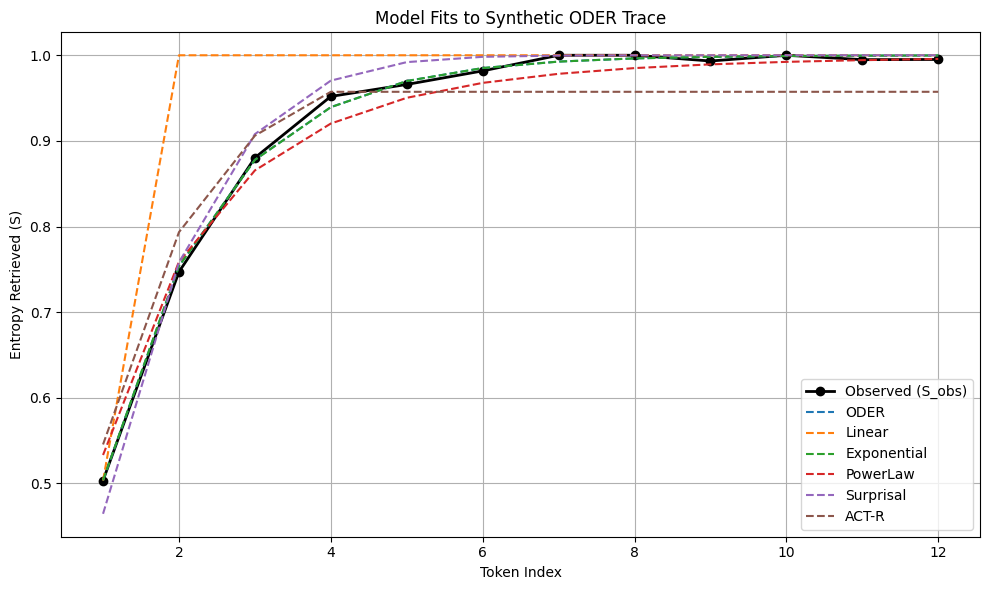

In [3]:
import matplotlib.pyplot as plt

# Define fitted versions of each model
model_funcs = {
    "ODER": lambda t, p: oder_model(t, *p),
    "Linear": lambda t, p: linear_model(t, *p),
    "Exponential": lambda t, p: exponential_model(t, *p),
    "PowerLaw": lambda t, p: power_law_model(t, *p),
    "Surprisal": lambda t, p: surprisal_exponential(t, *p, surprisal_values=surprisal_values),
    "ACT-R": lambda t, p: actr_buffer_decay(t, *p)
}

plt.figure(figsize=(10, 6))
plt.plot(t, S_obs, 'ko-', label="Observed (S_obs)", linewidth=2)

for _, row in df.iterrows():
    model = row["Model"]
    params = row["Params"]
    pred = model_funcs[model](t, params)
    plt.plot(t, pred, label=f"{model}", linestyle="--")

plt.xlabel("Token Index")
plt.ylabel("Entropy Retrieved (S)")
plt.title("Model Fits to Synthetic ODER Trace")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
